# **Rest-Mex**
## *Notebook Exploratorio*: Train-Set
---

### **Librerias y Descargas**

In [57]:
# Librerias necesarias

import re
import nltk
import gzip
import joblib
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
nltk.download('stopwords')

In [ ]:
nltk.download('punkt')

### **Estructura del DataSet**

In [2]:
# Ruta del train dataset
train_path = '../data/train/Rest-Mex_2025_train.csv'

# Leemos el CSV y guardamos en un df 
df_train = pd.read_csv(train_path)

# Mostramos las primeras filas del df
df_train.head()

,Title,Review,Polarity,Town,Region,Type
0,Mi Lugar Favorito!!!!,Excelente lugar para comer y pasar una buena n...,5.0,Sayulita,Nayarit,Restaurant
1,lugares interesantes para visitar,"andar mucho, así que un poco difícil para pers...",4.0,Tulum,QuintanaRoo,Attractive
2,No es el mismo Dreams,"Es nuestra cuarta visita a Dreams Tulum, elegi...",3.0,Tulum,QuintanaRoo,Hotel
3,un buen panorama cerca de CancÃºn,"Estando en CancÃºn, fuimos al puerto y tomamos...",4.0,Isla_Mujeres,QuintanaRoo,Attractive
4,El mejor,Es un lugar antiguo y por eso me encanto tiene...,5.0,Patzcuaro,Michoacan,Hotel


In [3]:
# Tamaño del df
print(f'Train-Dataset shape: {df_train.shape}')

# Informacion del df 
print('\n Train-Datset info:')
df_train.info()

Train-Dataset shape: (208051, 6)

 Train-Datset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208051 entries, 0 to 208050
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Title     208049 non-null  object 
 1   Review    208051 non-null  object 
 2   Polarity  208051 non-null  float64
 3   Town      208051 non-null  object 
 4   Region    208051 non-null  object 
 5   Type      208051 non-null  object 
dtypes: float64(1), object(5)
memory usage: 9.5+ MB


In [4]:
# Verificamos valores faltantes en cada columna
missing_values = df_train.isnull().sum()

# Calculamos el porcentaje de valores faltantes
missing_percentage = (missing_values / len(df_train)) * 100

# Creamos un df con ambos datos 
missing_info = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage': missing_percentage})

# Mostramso el df
missing_info.head()


,Missing Count,Missing Percentage
Title,2,0.000961
Review,0,0.000000
Polarity,0,0.000000
Town,0,0.000000
Region,0,0.000000


In [5]:
# Para identificar las columnas categoricas (se suelen guardar del tipo 'object' o 'category')
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns

# Imprime lo encontrado
print(f'Categorical columns found: {list(categorical_cols)}')

# No mostramos Review
categorical_cols = categorical_cols.drop(['Review'])

# Imprimimos los valores repetidos para cada columna
for col in categorical_cols:
    print(f'Value counts for {col}')
    print(df_train[col].value_counts())
    print('\n')

Categorical columns found: ['Title', 'Review', 'Town', 'Region', 'Type']
Value counts for Title
Title
Excelente                                                                 1747
Excelente servicio                                                         764
Excelente lugar                                                            723
Delicioso                                                                  649
Hermoso                                                                    518
                                                                          ... 
Una estancia de una noche en el hotel Xibalba, alias construcción zona       1
Ocean suite ático piscina paraíso                                            1
Fantástico entorno, evitar la excursión Booth timo!                          1
Increíble lugar y comida                                                     1
Un Tepoz debe                                                                1
Name: count, Length: 142966, 

In [6]:
# Calculamos estadistica descriptiva para la columna numerica
numerical_stats = df_train.describe()

# Imprimimos
print('Descriptive Statistics for Numerical Columns:')
print(numerical_stats)

Descriptive Statistics for Numerical Columns:
            Polarity
count  208051.000000
mean        4.450500
std         0.932237
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000


### **Distribucion de las Etiquetas**

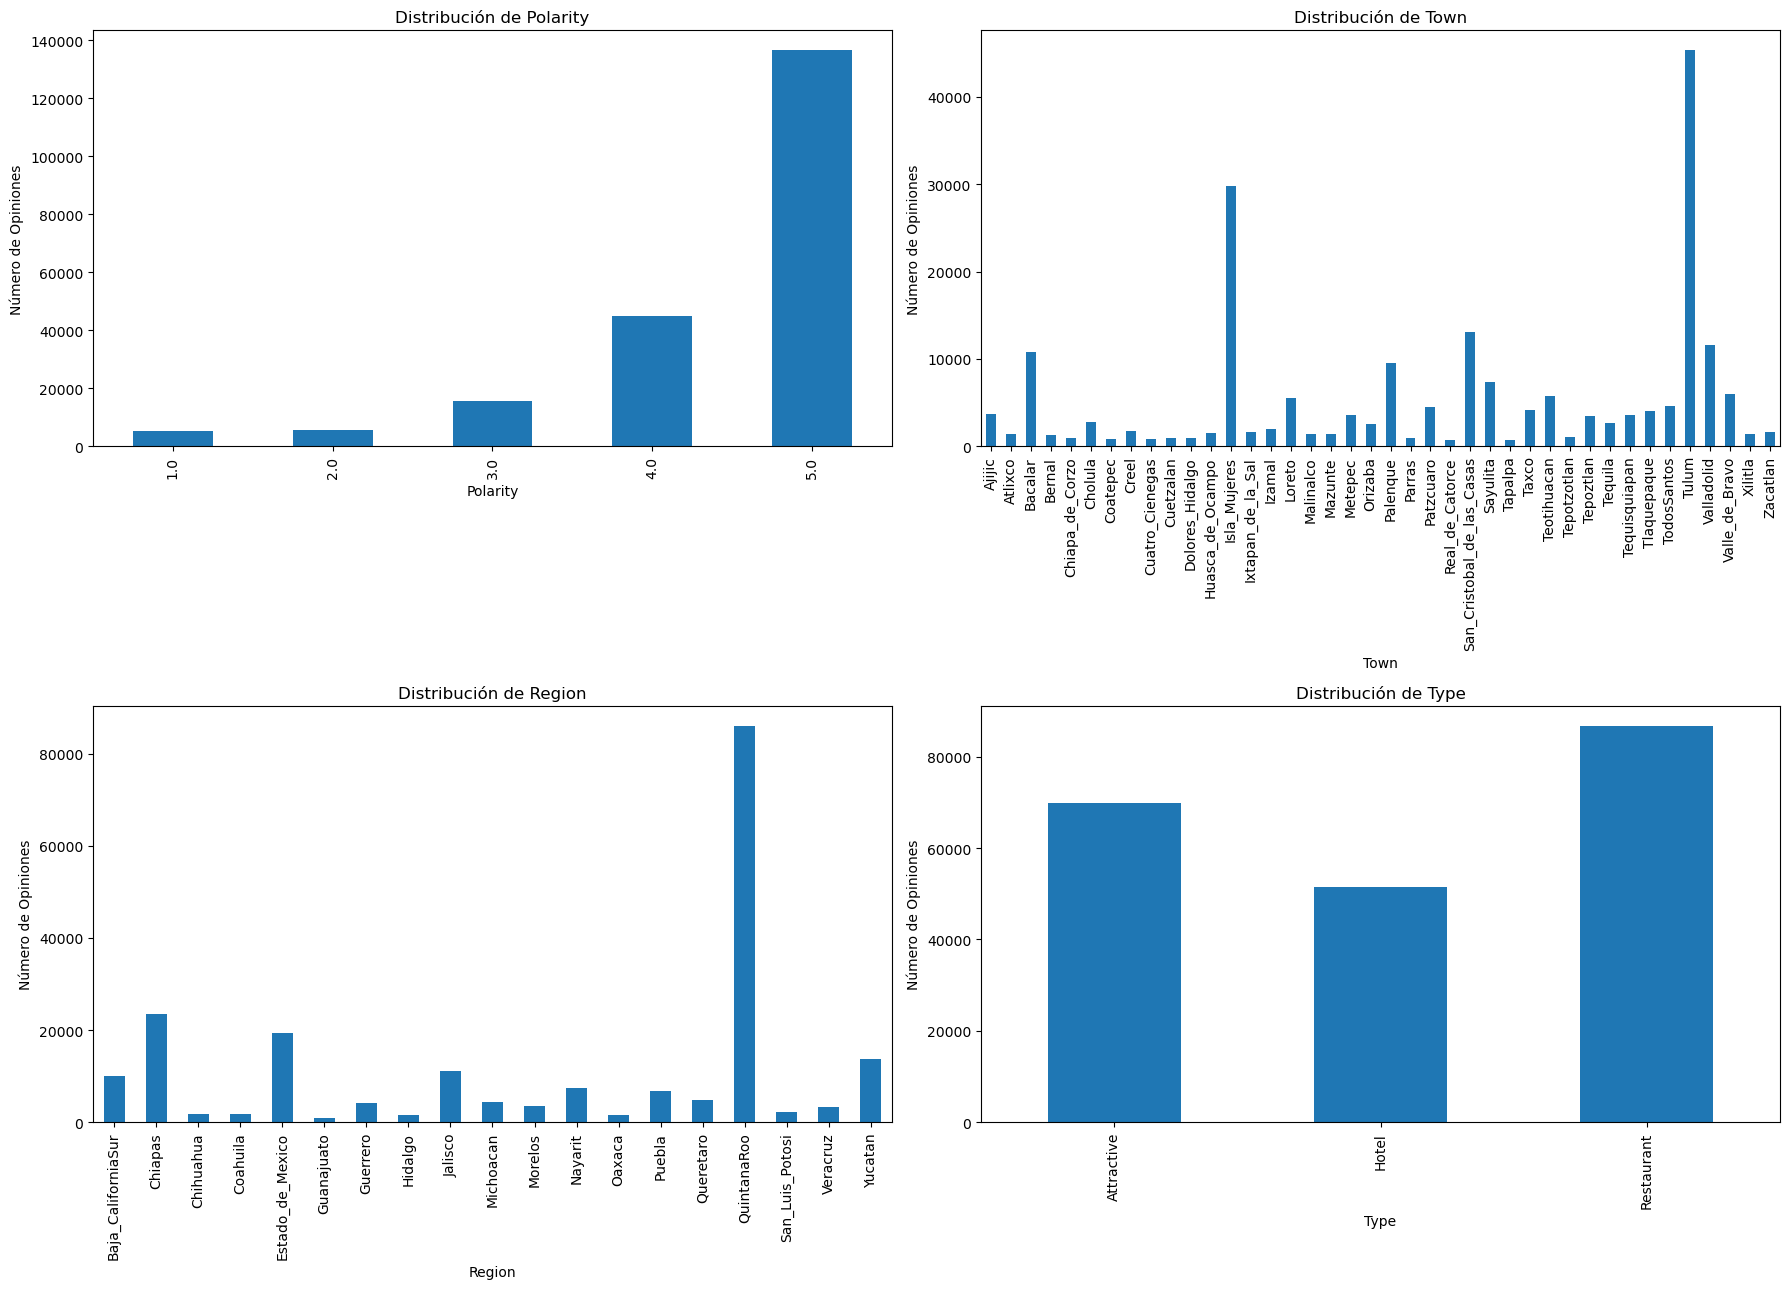

In [7]:
# Lista de las columnas de las etiquetas a observar su distribucion
label_cols = ['Polarity', 'Town', 'Region', 'Type']

# Creamos subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,13))  
axes = axes.flatten()  

# Loop para cada label
for idx, col in enumerate(label_cols):
    df_train[col].value_counts().sort_index().plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f"Distribución de {col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Número de Opiniones")

# Ajustamos espacio
plt.tight_layout()
plt.show()


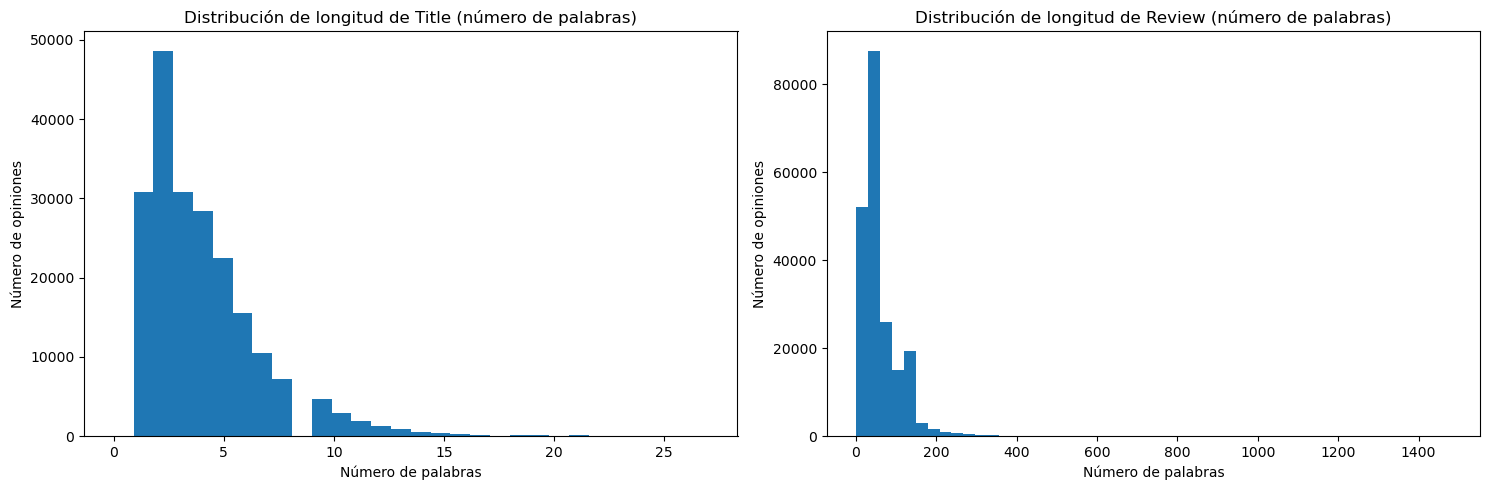

In [8]:
# Creamos columnas auxiliares para longitud
df_train['Title_length'] = df_train['Title'].apply(lambda x: len(str(x).split()))
df_train['Review_length'] = df_train['Review'].apply(lambda x: len(str(x).split()))

# Hacemos histogramas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Longitud de los Titles
df_train['Title_length'].plot(kind='hist', bins=30, ax=axes[0])
axes[0].set_title('Distribución de longitud de Title (número de palabras)')
axes[0].set_xlabel('Número de palabras')
axes[0].set_ylabel('Número de opiniones')

# Longitud de los Reviews
df_train['Review_length'].plot(kind='hist', bins=50, ax=axes[1])
axes[1].set_title('Distribución de longitud de Review (número de palabras)')
axes[1].set_xlabel('Número de palabras')
axes[1].set_ylabel('Número de opiniones')

plt.tight_layout()
plt.show()

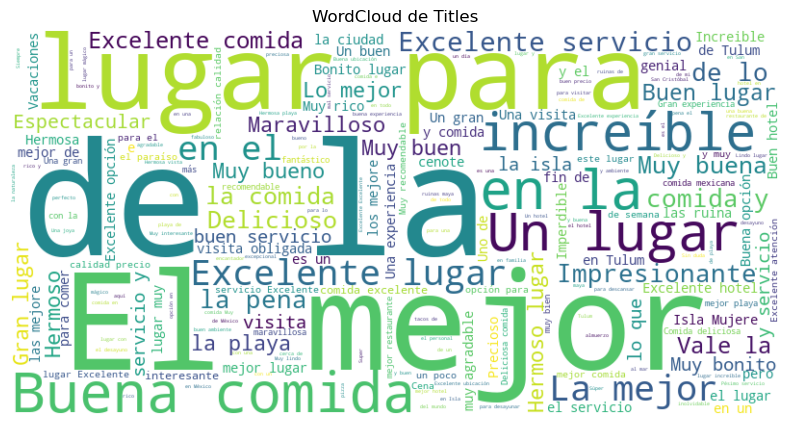

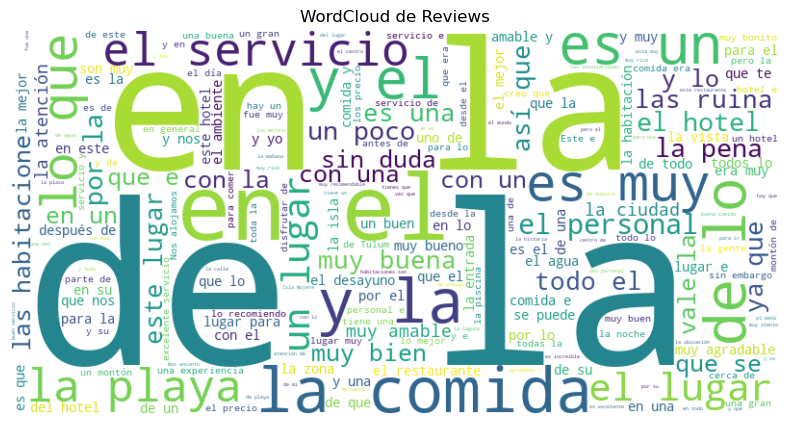

In [9]:
# WordCloud para Titles
text_titles = " ".join(str(title) for title in df_train['Title'] if pd.notnull(title))
wordcloud_titles = WordCloud(width=800, height=400, background_color='white').generate(text_titles)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud de Titles')
plt.show()

# WordCloud para Reviews
text_reviews = " ".join(str(review) for review in df_train['Review'] if pd.notnull(review))
wordcloud_reviews = WordCloud(width=800, height=400, background_color='white').generate(text_reviews)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_reviews, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud de Reviews')
plt.show()

### **Limpieza del Texto**

No eliminamos stopwords ya que son necesarias para el analisis de sentimientos

In [10]:
# Eliminamos las columnas auxiliares creadas
df_train.drop(columns=['Title_length', 'Review_length'])

# Creamos un df donde realizaremos la limpieza
df_train_clean = df_train

In [11]:
def tokenize_clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Pasamos el texto a minusculas
    text = text.lower()
    
    # Elimina acentos
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    
    # Tokenizar
    tokens = word_tokenize(text)
    
    # Filtrar tokens: dejamos palabras y signos de exclamacion o interrogacion
    tokens = [token for token in tokens if token.isalpha() or token in ['!', '?']]
    
    # Unimos los tokens de nuevo en texto
    text = ' '.join(tokens)
    
    # Elimina multiples espacios 
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [12]:
# Tokenizamos respetando emociones
df_train_clean['Title'] = df_train_clean['Title'].apply(tokenize_clean_text)
df_train_clean['Review'] = df_train_clean['Review'].apply(tokenize_clean_text)

In [14]:
# Observamos los resultados tras limpieza
df_train_clean.head()

,Title,Review,Polarity,Town,Region,Type,Title_length,Review_length
0,mi lugar favorito ! ! ! !,excelente lugar para comer y pasar una buena n...,5.0,Sayulita,Nayarit,Restaurant,3,18
1,lugares interesantes para visitar,andar mucho asi que un poco dificil para perso...,4.0,Tulum,QuintanaRoo,Attractive,4,38
2,no es el mismo dreams,es nuestra cuarta visita a dreams tulum elegim...,3.0,Tulum,QuintanaRoo,Hotel,5,136
3,un buen panorama cerca de cancaon,estando en cancaon fuimos al puerto y tomamos ...,4.0,Isla_Mujeres,QuintanaRoo,Attractive,6,91
4,el mejor,es un lugar antiguo y por eso me encanto tiene...,5.0,Patzcuaro,Michoacan,Hotel,2,47


### **TF-IDF** y **Bigramas**

Nos centramos en analisis de sentimientos

In [15]:
# Creamos un nuevo df y nos quedamos con las columnas necesarias
df_reviews = df_train_clean[['Review', 'Polarity']].dropna()

# Vemos cuantas opiniones hay por polaridad
print(df_reviews['Polarity'].value_counts())

Polarity
5.0    136561
4.0     45034
3.0     15519
2.0      5496
1.0      5441
Name: count, dtype: int64


In [ ]:
# Cargar stopwords en español
spanish_stopwords = stopwords.words('spanish')  # Siempre si eliminamos stopwords

# Creamos el TF-IDF vectorizado
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=spanish_stopwords)  # Considerar el numero de features
                                                                             
# Ajustamos y transformamos los textos
X_tfidf = tfidf_vectorizer.fit_transform(df_reviews['Review'])

# Mapeo de indice a palabra
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [17]:
# Vamos a crear la media TF-IDF por polaridad 
polarities = df_reviews['Polarity'].unique()

# Lista para las palabras mas repetidas
top_words_by_polarity = {}

for polarity in sorted(polarities):
    # Indices de documentos de esta polaridad
    idx = df_reviews['Polarity'] == polarity
    X_sub = X_tfidf[idx]  

    # Calculamos la media por columna (palabra)
    mean_tfidf = X_sub.mean(axis=0).A1  
    top_indices = np.argsort(mean_tfidf)[::-1][:15]  # Top 15 palabras
    top_words = tfidf_feature_names[top_indices]
    
    top_words_by_polarity[polarity] = top_words.tolist()

# Imprimir resultados
for polarity, words in top_words_by_polarity.items():
    print(f"\nTop palabras para Polaridad {polarity}:")
    print(words)


Top palabras para Polaridad 1.0:
['mas', 'hotel', 'servicio', 'lugar', 'mal', 'habitacion', 'comida', 'pesimo', 'si', 'mala', 'habia', 'solo', 'peor', 'despues', 'restaurante']

Top palabras para Polaridad 2.0:
['mas', 'hotel', 'comida', 'servicio', 'lugar', 'habitacion', 'si', 'solo', 'mal', 'habia', 'mala', 'bien', 'restaurante', 'personal', 'habitaciones']

Top palabras para Polaridad 3.0:
['mas', 'lugar', 'comida', 'si', 'hotel', 'bien', 'servicio', 'buena', 'habitacion', 'solo', 'playa', 'restaurante', 'bueno', 'bastante', 'mejor']

Top palabras para Polaridad 4.0:
['lugar', 'buena', 'comida', 'mas', 'hotel', 'bien', 'si', 'playa', 'servicio', 'buen', 'agradable', 'restaurante', 'bueno', 'excelente', 'asi']

Top palabras para Polaridad 5.0:
['lugar', 'comida', 'excelente', 'servicio', 'mas', 'atencion', 'playa', 'mejor', 'buena', 'hotel', 'si', 'increible', 'personal', 'bien', 'super']


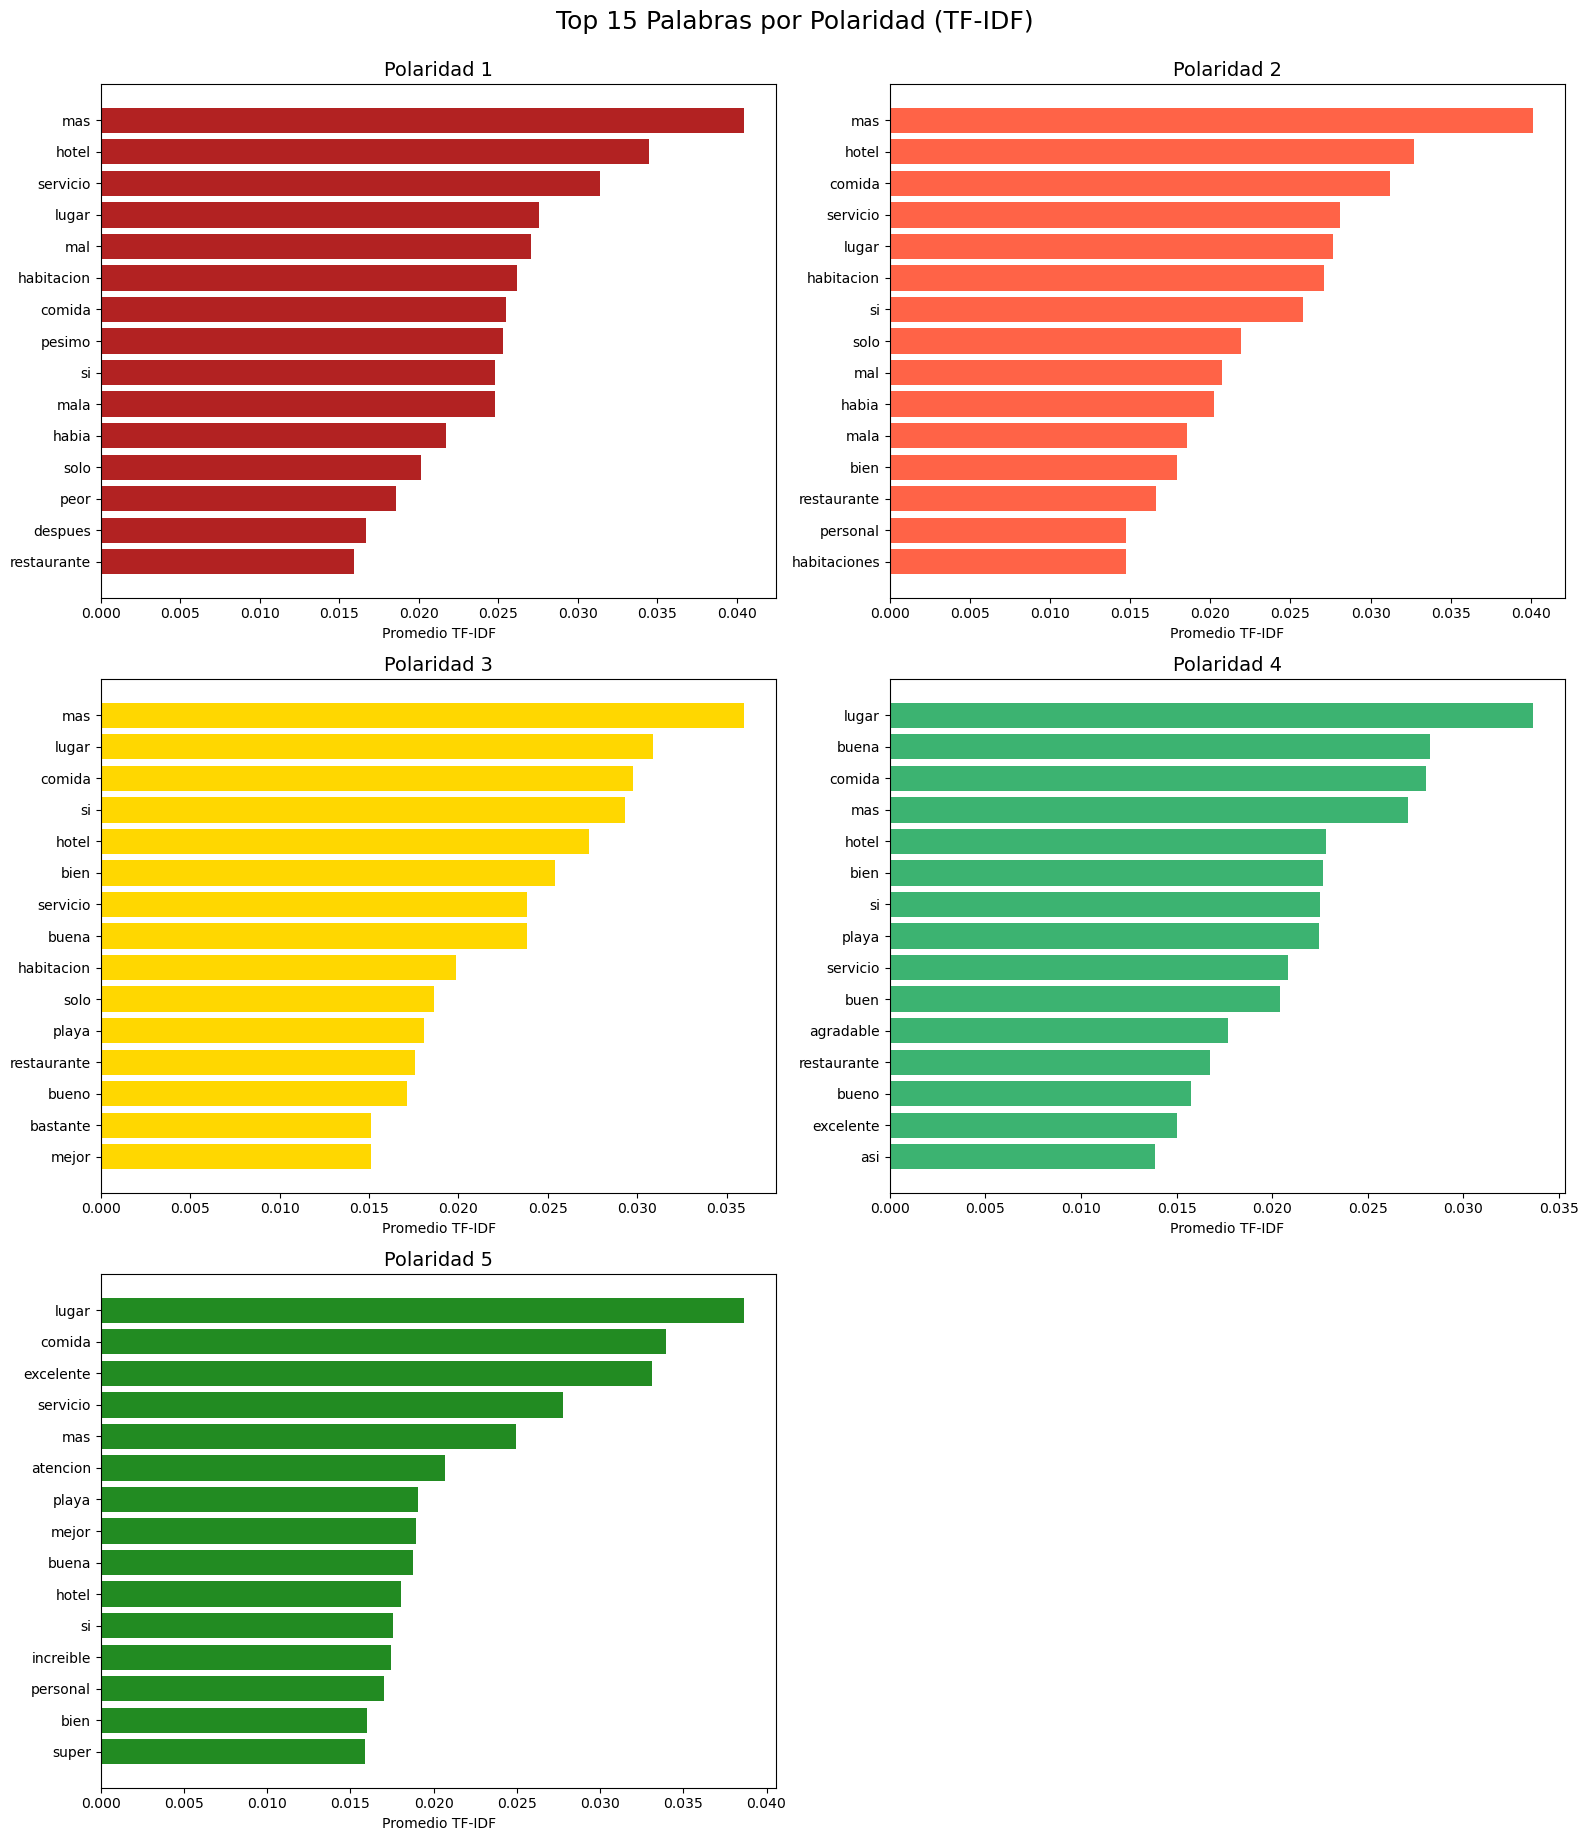

In [ ]:
# Definimos colores por polaridad 
colors = {
    1.0: 'firebrick',       # Rojo fuerte para muy negativo
    2.0: 'tomato',          # Rojo más claro
    3.0: 'gold',            # Amarillo para neutral
    4.0: 'mediumseagreen',  # Verde claro para positivo
    5.0: 'forestgreen'      # Verde oscuro para muy positivo
}

# Creamos figura y subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))  
axes = axes.flatten()

# Para cada polaridad, graficamos en un subplot
for idx, polarity in enumerate(sorted(df_reviews['Polarity'].unique())):
    idx_docs = df_reviews['Polarity'] == polarity
    X_sub = X_tfidf[idx_docs]

    # Media de TF-IDF
    mean_tfidf = X_sub.mean(axis=0).A1
    top_indices = np.argsort(mean_tfidf)[::-1][:15]
    
    top_words = tfidf_feature_names[top_indices]
    top_scores = mean_tfidf[top_indices]
    
    # Graficamos
    ax = axes[idx]
    y_pos = np.arange(len(top_words))
    
    ax.barh(y_pos, top_scores, color=colors.get(polarity, 'blue'))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_words)
    ax.invert_yaxis()
    ax.set_xlabel('Promedio TF-IDF')
    ax.set_title(f'Polaridad {int(polarity)}', fontsize=14)
    
# Ajustamos espacio
plt.tight_layout()

# Eliminamos el subplot vacio que queda
fig.delaxes(axes[-1])

# Titulo general
fig.suptitle('Top 15 Palabras por Polaridad (TF-IDF)', fontsize=18, y=1.02)

plt.show()

In [19]:
# Vectorizador de BIGRAMAS
bigram_vectorizer = TfidfVectorizer(max_features=5000,
                                    stop_words=spanish_stopwords,   # Misma lista de stopwords de antes
                                    ngram_range=(2,2))              # <- Muy importante: 2 palabras juntas

# Ajustar y transformar
X_bigram = bigram_vectorizer.fit_transform(df_reviews['Review'])

# Obtener nombres de los bigramas
bigram_feature_names = bigram_vectorizer.get_feature_names_out()

In [20]:
# Guardaremos top bigramas por polaridad
top_bigrams_by_polarity = {}

for polarity in sorted(df_reviews['Polarity'].unique()):
    idx_docs = df_reviews['Polarity'] == polarity
    X_sub = X_bigram[idx_docs]

    mean_tfidf = X_sub.mean(axis=0).A1
    top_indices = np.argsort(mean_tfidf)[::-1][:15]
    
    top_bigrams = bigram_feature_names[top_indices]
    
    top_bigrams_by_polarity[polarity] = top_bigrams.tolist()

# Mostrar los resultados
for polarity, bigrams in top_bigrams_by_polarity.items():
    print(f"\nTop BIGRAMAS para Polaridad {polarity}:")
    print(bigrams)


Top BIGRAMAS para Polaridad 1.0:
['pesimo servicio', 'mal servicio', 'mala experiencia', 'servicio pesimo', 'agua caliente', 'aire acondicionado', 'vale pena', 'comida mala', 'lugar bonito', 'deja desear', 'servicio lento', 'mala calidad', 'dia siguiente', 'tarjeta credito', 'fin semana']

Top BIGRAMAS para Polaridad 2.0:
['aire acondicionado', 'servicio lento', 'deja desear', 'agua caliente', 'vale pena', 'mal servicio', 'lugar bonito', 'comida buena', 'comida mala', 'si quieres', 'unico bueno', 'mala experiencia', 'servicio malo', 'pesimo servicio', 'dia siguiente']

Top BIGRAMAS para Polaridad 3.0:
['comida buena', 'vale pena', 'lugar bonito', 'servicio lento', 'servicio bueno', 'aire acondicionado', 'comida bien', 'lugar agradable', 'personal amable', 'buen lugar', 'si quieres', 'deja desear', 'agua caliente', 'puede ser', 'buena comida']

Top BIGRAMAS para Polaridad 4.0:
['vale pena', 'comida buena', 'buena comida', 'buen servicio', 'personal amable', 'buen lugar', 'servicio buen

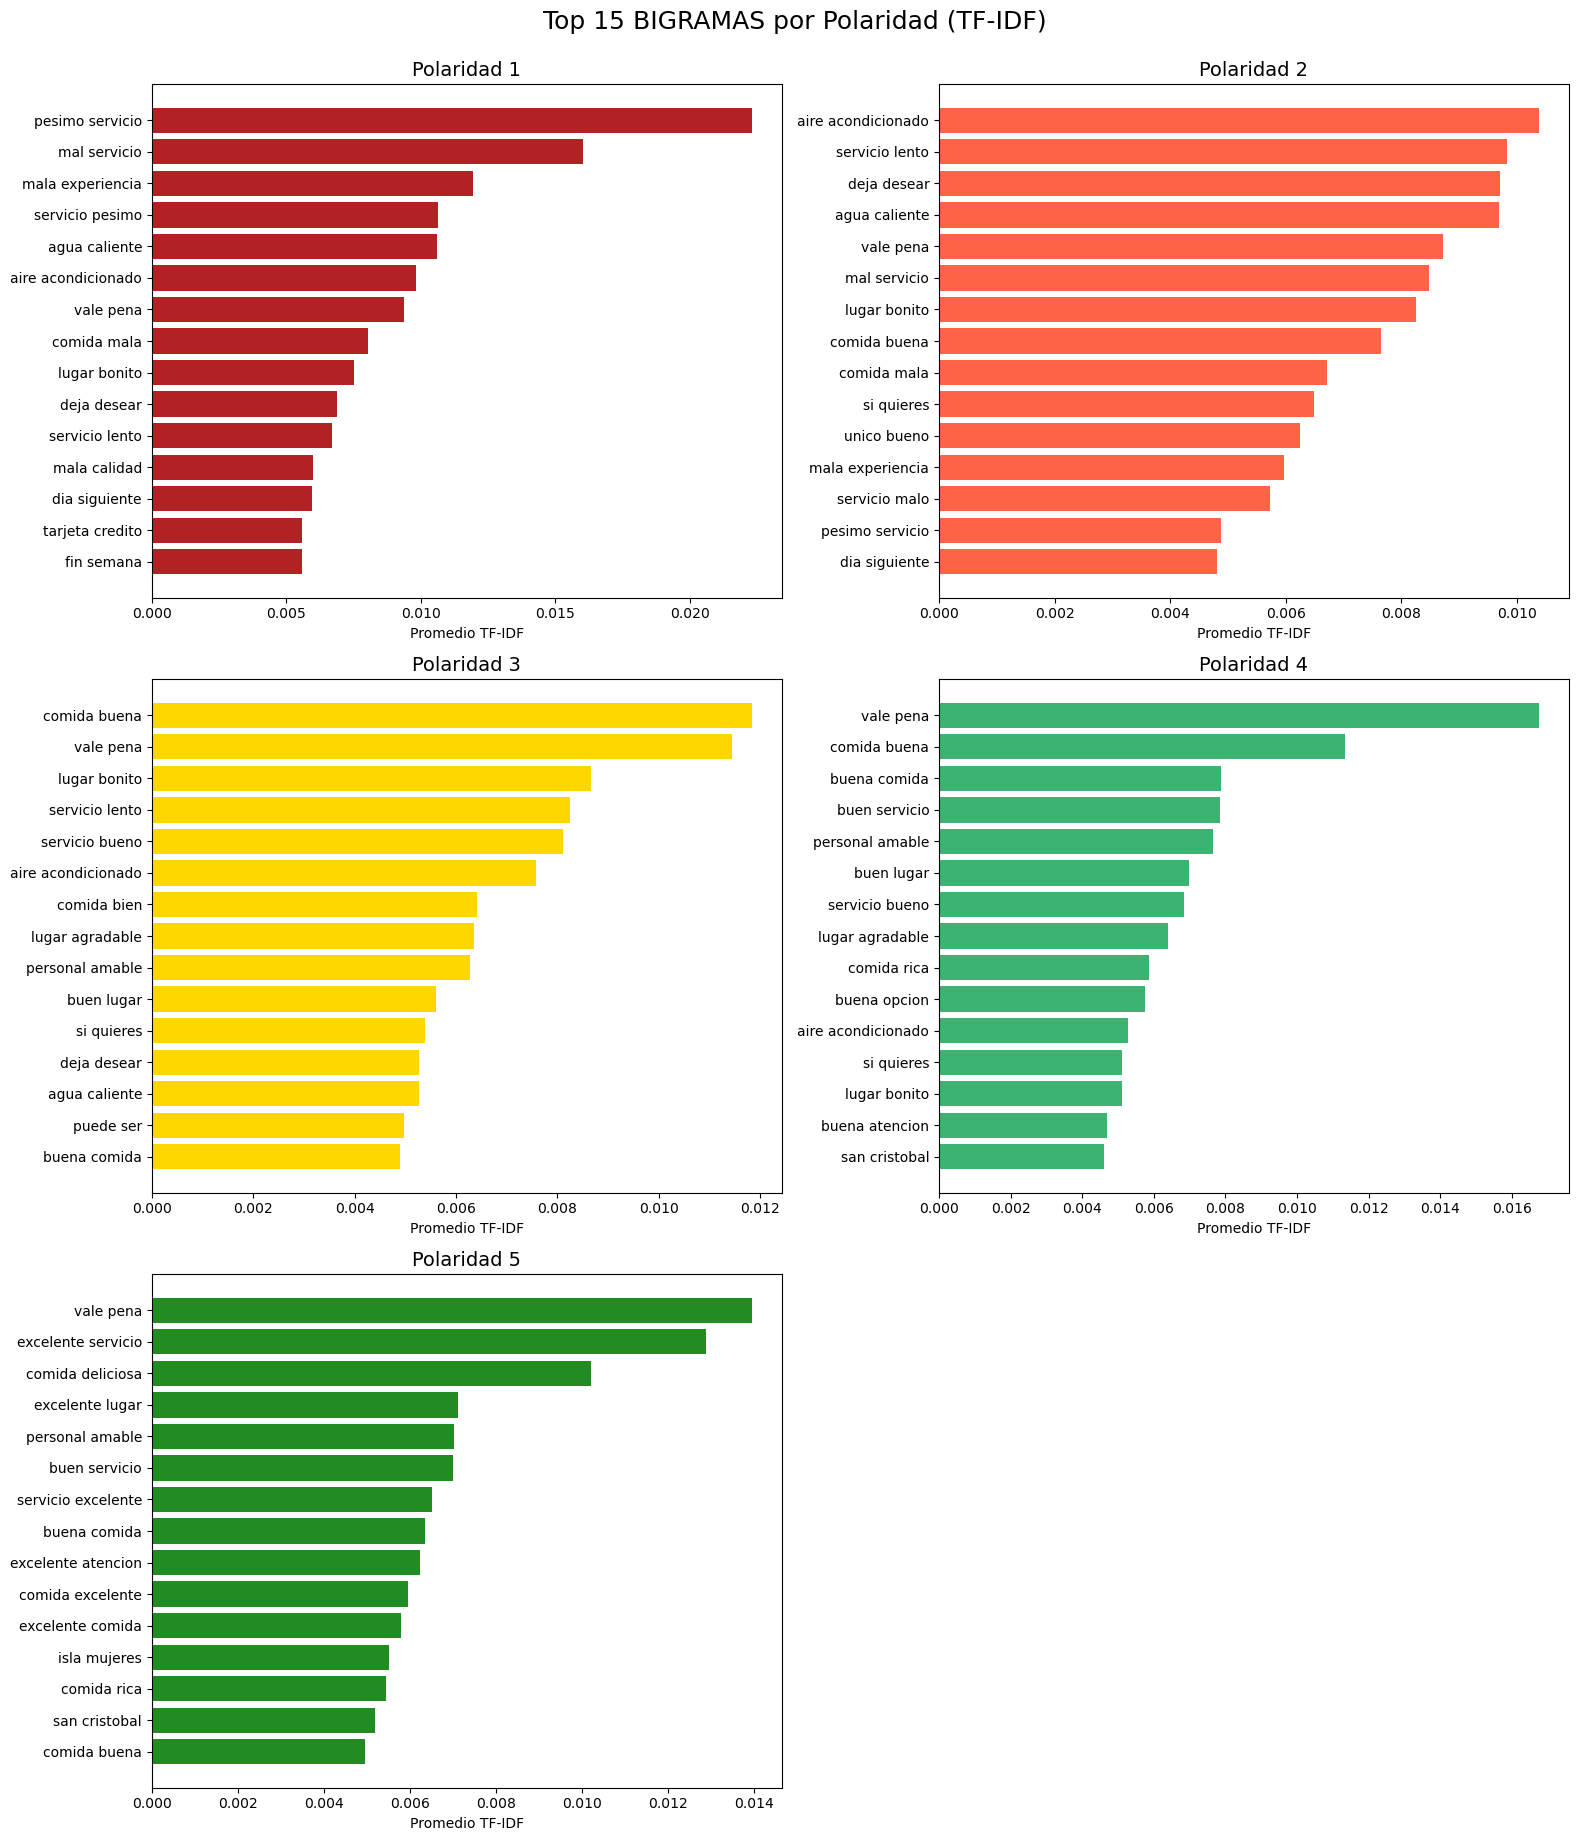

In [21]:

# Volvemos a definir colores 
colors = {
    1.0: 'firebrick',
    2.0: 'tomato',
    3.0: 'gold',
    4.0: 'mediumseagreen',
    5.0: 'forestgreen'
}

# Creamos figura y subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))  
axes = axes.flatten()

for idx, polarity in enumerate(sorted(top_bigrams_by_polarity.keys())):
    bigrams = top_bigrams_by_polarity[polarity]
    
    # Para graficar, necesitamos las scores tambien
    idx_docs = df_reviews['Polarity'] == polarity
    X_sub = X_bigram[idx_docs]
    
    mean_tfidf = X_sub.mean(axis=0).A1
    bigram_indices = [np.where(bigram_feature_names == bigram)[0][0] for bigram in bigrams]
    scores = mean_tfidf[bigram_indices]
    
    # Graficamos
    ax = axes[idx]
    y_pos = np.arange(len(bigrams))
    
    ax.barh(y_pos, scores, color=colors.get(polarity, 'blue'))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(bigrams)
    ax.invert_yaxis()
    ax.set_xlabel('Promedio TF-IDF')
    ax.set_title(f'Polaridad {int(polarity)}', fontsize=14)

# Ajuste de espacio
plt.tight_layout()

# Eliminamos el subplot vacio sobrante
fig.delaxes(axes[-1])

# Titulo general
fig.suptitle('Top 15 BIGRAMAS por Polaridad (TF-IDF)', fontsize=18, y=1.02)

plt.show()

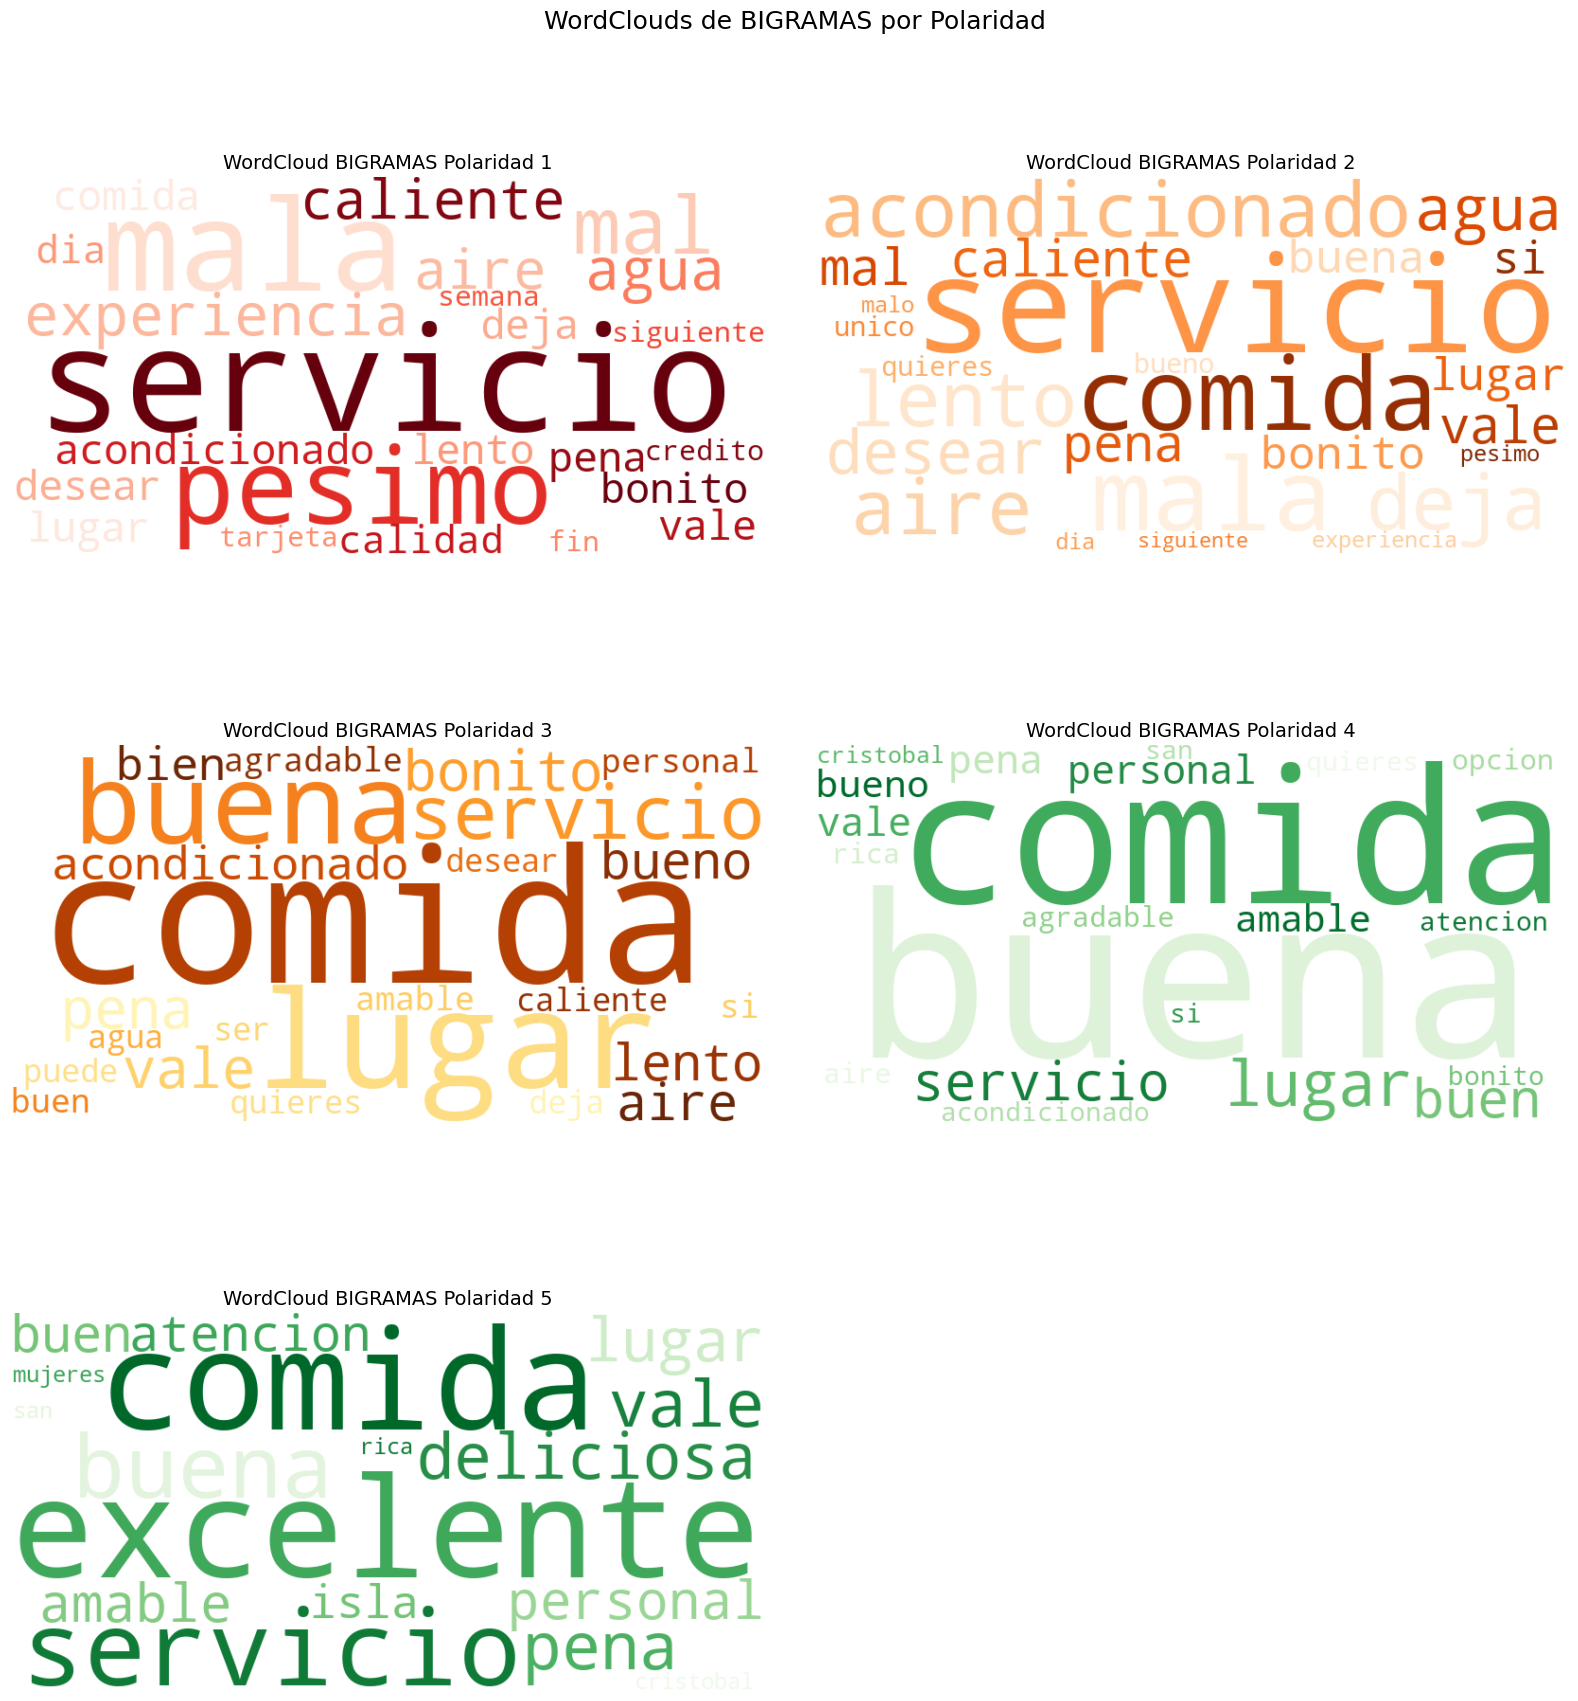

In [22]:
# Definimos colores base por polaridad
colors = {
    1.0: 'Reds',
    2.0: 'Oranges',
    3.0: 'YlOrBr',
    4.0: 'Greens',
    5.0: 'Greens_r'
}

# Creamos figura
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,18))
axes = axes.flatten()

# Crear un WordCloud para cada polaridad
for idx, polarity in enumerate(sorted(top_bigrams_by_polarity.keys())):
    bigrams = top_bigrams_by_polarity[polarity]
    text = " ".join(bigrams)  # Unimos todos los bigramas como texto
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colors.get(polarity, 'Blues'),
        collocations=False,  # Importante: no juntar bigramas de nuevo
        prefer_horizontal=1.0
    ).generate(text)
    
    ax = axes[idx]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'WordCloud BIGRAMAS Polaridad {int(polarity)}', fontsize=14)

# Ajustamos y eliminamos el subplot vacio
plt.tight_layout()
fig.delaxes(axes[-1])

# Titulo general
fig.suptitle('WordClouds de BIGRAMAS por Polaridad', fontsize=18, y=1.02)

plt.show()

### **Modelos Clasicos**: *NB, RegLog, SVM*

In [23]:
# Definimos el vectorizador TF-IDF final
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,             # Ajustamos a 10000 features para buen balance
    stop_words=spanish_stopwords,
    ngram_range=(1,2)               # Incluimos unigramas y bigramas
)

# Aplicamos sobre las reseñas limpias
X_train = tfidf_vectorizer.fit_transform(df_reviews['Review'])

# Definimos etiquetas: primero atacaremos la predicción de Polaridad
y_train = df_reviews['Polarity']

**Naive Bayes**

In [24]:
# Entrenamos el modelo
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predicciones en train (por ahora)
y_pred_nb = nb_model.predict(X_train)

print("Resultados Multinomial Naive Bayes:")
print("Accuracy:", accuracy_score(y_train, y_pred_nb))
print(classification_report(y_train, y_pred_nb))

Resultados Multinomial Naive Bayes:
Accuracy: 0.703212193164176
              precision    recall  f1-score   support

         1.0       0.66      0.46      0.54      5441
         2.0       0.71      0.05      0.09      5496
         3.0       0.47      0.18      0.26     15519
         4.0       0.48      0.23      0.31     45034
         5.0       0.74      0.96      0.83    136561

    accuracy                           0.70    208051
   macro avg       0.61      0.37      0.41    208051
weighted avg       0.66      0.70      0.65    208051



**Regresion Logistica**

In [25]:
# Entrenamos el modelo
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_train)

print("\nResultados Logistic Regression:")
print("Accuracy:", accuracy_score(y_train, y_pred_lr))
print(classification_report(y_train, y_pred_lr))

c:\Users\diego\miniconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Resultados Logistic Regression:
Accuracy: 0.7453220604563304
              precision    recall  f1-score   support

         1.0       0.68      0.62      0.65      5441
         2.0       0.61      0.24      0.35      5496
         3.0       0.56      0.38      0.45     15519
         4.0       0.55      0.36      0.44     45034
         5.0       0.80      0.94      0.86    136561

    accuracy                           0.75    208051
   macro avg       0.64      0.51      0.55    208051
weighted avg       0.72      0.75      0.72    208051



**SVM**

In [26]:
# Entrenamos el modelo
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predicciones
y_pred_svm = svm_model.predict(X_train)

print("\nResultados Linear SVM:")
print("Accuracy:", accuracy_score(y_train, y_pred_svm))
print(classification_report(y_train, y_pred_svm))


Resultados Linear SVM:
Accuracy: 0.7527625437993569
              precision    recall  f1-score   support

         1.0       0.74      0.73      0.74      5441
         2.0       0.74      0.34      0.47      5496
         3.0       0.62      0.37      0.46     15519
         4.0       0.57      0.34      0.42     45034
         5.0       0.79      0.95      0.86    136561

    accuracy                           0.75    208051
   macro avg       0.69      0.55      0.59    208051
weighted avg       0.73      0.75      0.72    208051



**Para Guardar y Cargar el Mejor Modelo**: 

In [ ]:
# Guardar el mejor modelo entrenado (Linear SVM)

# Define la ruta y nombre de archivo
model_filename = '../model/svm_polarity_model.pkl'

# Guardamos el modelo
joblib.dump(svm_model, model_filename)

print(f"Modelo guardado exitosamente como {model_filename}")

In [ ]:
# Cargar el modelo guardado
svm_model_loaded = joblib.load('../model/svm_polarity_model.pkl')

# Ya puedes usarlo directamente para predecir
y_pred = svm_model_loaded.predict(X_train)

print("Predicción realizada exitosamente usando el modelo cargado.")

In [ ]:
# Guardar el vectorizador TF-IDF
vectorizer_filename = '../model/tfidf_vectorizer.pkl'
joblib.dump(tfidf_vectorizer, vectorizer_filename)

print(f"Vectorizador guardado exitosamente como {vectorizer_filename}")

### **Embeggings**: *Word2Vcec y Doc2Vec*

**Word2Vce**

In [44]:
# Creamos el coprus
corpus_vocab = set()

for review in df_reviews['Review']:
    if isinstance(review, str):
        tokens = review.split()  # SOLO tokenizamos, porque ya está limpio
        corpus_vocab.update(tokens)

print(f"Vocabulario total en corpus: {len(corpus_vocab)} palabras únicas.")

Vocabulario total en corpus: 101220 palabras únicas.


In [49]:
# Función para normalizar palabras
def normalize_word(word):
    word = word.lower()
    word = unicodedata.normalize('NFKD', word).encode('ASCII', 'ignore').decode('utf-8')
    return word

# Path del archivo descargado
embedding_path = '../data/embeddings/cc.es.300.vec.gz'

# Inicializamos el diccionario donde guardaremos los embeddings
word2vec = {}

# Abrimos el archivo .gz de FastText en modo texto
with gzip.open(embedding_path, 'rt', encoding='utf-8') as f:
    first_line = f.readline()  # Saltamos la primera línea que solo tiene metadata
    print(f"Primera línea saltada (metadata): {first_line.strip()}")
    
    for line in f:
        parts = line.strip().split()
        
        if len(parts) <= 2:
            continue  # Si no tiene suficientes dimensiones, ignoramos
        
        word = parts[0]
        norm_word = normalize_word(word)  # Normalizamos
        
        if norm_word in corpus_vocab:
            try:
                vector = [float(val) for val in parts[1:]]
                word2vec[norm_word] = vector
            except ValueError:
                continue  # En caso de error numérico, ignoramos

print(f"Se cargaron {len(word2vec)} embeddings del corpus.")

Primera línea saltada (metadata): 2000000 300
Se cargaron 76831 embeddings del corpus.


In [50]:
# Funcion para convertir una reseña en su vector promedio
def review_to_vector(review, word2vec, embedding_dim=300):
    if not isinstance(review, str):
        return np.zeros(embedding_dim)
    
    tokens = review.split()
    vectors = []
    
    for token in tokens:
        if token in word2vec:
            vectors.append(word2vec[token])
    
    if len(vectors) == 0:
        return np.zeros(embedding_dim)  # Si ninguna palabra esta en el vocabulario, vector de ceros
    
    return np.mean(vectors, axis=0)

# Aplicamos a todas las reseñas
X_word2vec = np.vstack(
    df_reviews['Review'].apply(lambda x: review_to_vector(x, word2vec)).values
)

print(f"Shape de X_word2vec: {X_word2vec.shape}")

Shape de X_word2vec: (208051, 300)


In [52]:
# Los datos
X = X_word2vec
y = df_reviews['Polarity'].values  # Etiquetas

# Split 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape X_train:", X_train.shape)
print("Shape X_val:", X_val.shape)

Shape X_train: (166440, 300)
Shape X_val: (41611, 300)


**Naive Bayes**

In [ ]:
# --- Naive Bayes ---
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_val)

print("\nResultados Naive Bayes (Gaussiano):")
print(f"Accuracy: {accuracy_score(y_val, y_pred_nb):.4f}")
print(classification_report(y_val, y_pred_nb, digits=4))


Resultados Naive Bayes (Gaussiano):
Accuracy: 0.3624
              precision    recall  f1-score   support

         1.0     0.1164    0.3741    0.1775      1088
         2.0     0.0538    0.3621    0.0937      1099
         3.0     0.1138    0.2339    0.1531      3104
         4.0     0.2422    0.2804    0.2599      9007
         5.0     0.7928    0.4036    0.5349     27313

    accuracy                         0.3624     41611
   macro avg     0.2638    0.3308    0.2438     41611
weighted avg     0.5858    0.3624    0.4259     41611



**Regresion Logistica**

In [55]:
# --- Logistic Regression ---
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_val)

print("\nResultados Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_logreg):.4f}")
print(classification_report(y_val, y_pred_logreg, digits=4))


Resultados Logistic Regression:
Accuracy: 0.6702
              precision    recall  f1-score   support

         1.0     0.5100    0.1176    0.1912      1088
         2.0     0.5000    0.0009    0.0018      1099
         3.0     0.3567    0.0934    0.1481      3104
         4.0     0.3849    0.0815    0.1345      9007
         5.0     0.6919    0.9788    0.8108     27313

    accuracy                         0.6702     41611
   macro avg     0.4887    0.2545    0.2573     41611
weighted avg     0.5906    0.6702    0.5774     41611



**SVM**

In [56]:
# --- SVM ---
svm_model = LinearSVC(random_state=42, max_iter=10000)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

print("\nResultados SVM:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_svm):.4f}")
print(classification_report(y_val, y_pred_svm, digits=4))


Resultados SVM:
Accuracy: 0.6747
              precision    recall  f1-score   support

         1.0     0.5327    0.2169    0.3083      1088
         2.0     0.0000    0.0000    0.0000      1099
         3.0     0.4250    0.0702    0.1205      3104
         4.0     0.3808    0.1071    0.1672      9007
         5.0     0.6993    0.9759    0.8148     27313

    accuracy                         0.6747     41611
   macro avg     0.4076    0.2740    0.2822     41611
weighted avg     0.5871    0.6747    0.5881     41611



**Doc2Vec**

In [58]:
# Preparamos los datos para Doc2Vec
tagged_data = [
    TaggedDocument(words=review.split(), tags=[str(i)]) 
    for i, review in enumerate(df_reviews['Review'])
]

In [59]:
# Entrenamos el modelo
model_d2v = Doc2Vec(
    vector_size=300,   # Igual que Word2Vec 
    window=5,          # Context window
    min_count=2,       # Palabras menos frecuentes se eliminan
    workers=4,         # Número de núcleos para entrenar (ajustable)
    epochs=40,         # Número de iteraciones de entrenamiento
    dm=1,              # dm=1 significa Distributed Memory (mejor para semántica de documento)
    seed=42            # Reproducibilidad
)

model_d2v.build_vocab(tagged_data)
model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

In [60]:
# Obtenemos vectores de cada reseña
X_doc2vec = np.vstack([
    model_d2v.infer_vector(review.split()) for review in df_reviews['Review']
])

print(f"Shape de X_doc2vec: {X_doc2vec.shape}")

Shape de X_doc2vec: (208051, 300)


In [61]:
# 1. Hacemos split 80/20
X = X_doc2vec
y = df_reviews['Polarity'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape X_train:", X_train.shape)
print("Shape X_val:", X_val.shape)

Shape X_train: (166440, 300)
Shape X_val: (41611, 300)


**Naive Bayes**

In [62]:
# --- Naive Bayes Gaussiano ---
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_val)

print("\nResultados Naive Bayes Gaussiano sobre Doc2Vec:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_nb):.4f}")
print(classification_report(y_val, y_pred_nb, digits=4))


Resultados Naive Bayes Gaussiano sobre Doc2Vec:
Accuracy: 0.5089
              precision    recall  f1-score   support

         1.0     0.3325    0.2528    0.2872      1088
         2.0     0.0480    0.3685    0.0849      1099
         3.0     0.1322    0.0976    0.1123      3104
         4.0     0.2897    0.1019    0.1508      9007
         5.0     0.7170    0.7057    0.7113     27313

    accuracy                         0.5089     41611
   macro avg     0.3039    0.3053    0.2693     41611
weighted avg     0.5531    0.5089    0.5176     41611



**Regresion Logistica**

In [63]:
# --- Logistic Regression ---
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_val)

print("\nResultados Logistic Regression sobre Doc2Vec:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_logreg):.4f}")
print(classification_report(y_val, y_pred_logreg, digits=4))


Resultados Logistic Regression sobre Doc2Vec:
Accuracy: 0.6917
              precision    recall  f1-score   support

         1.0     0.4871    0.4522    0.4690      1088
         2.0     0.3088    0.0955    0.1459      1099
         3.0     0.3636    0.2036    0.2610      3104
         4.0     0.4459    0.1946    0.2710      9007
         5.0     0.7458    0.9446    0.8335     27313

    accuracy                         0.6917     41611
   macro avg     0.4703    0.3781    0.3961     41611
weighted avg     0.6341    0.6917    0.6413     41611



**SVM**

In [64]:
# --- SVM ---
svm_model = LinearSVC(random_state=42, max_iter=10000)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

print("\nResultados SVM sobre Doc2Vec:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_svm):.4f}")
print(classification_report(y_val, y_pred_svm, digits=4))


Resultados SVM sobre Doc2Vec:
Accuracy: 0.6849
              precision    recall  f1-score   support

         1.0     0.4910    0.4026    0.4424      1088
         2.0     0.3750    0.0027    0.0054      1099
         3.0     0.3827    0.0741    0.1242      3104
         4.0     0.4086    0.1568    0.2266      9007
         5.0     0.7207    0.9672    0.8260     27313

    accuracy                         0.6849     41611
   macro avg     0.4756    0.3207    0.3249     41611
weighted avg     0.6128    0.6849    0.6122     41611



In [65]:
# Guardar el modelo Doc2Vec
model_d2v.save('../model/doc2vec_model.model')

In [ ]:
# Para cargar el modelo en el futuro
model_d2v = Doc2Vec.load('../models/doc2vec_model.model')